------------------------
**COMMAND LINE PROCESSING**

In [1]:
# check whether we're running in Jupyter or from a script file
cmd_args = []

import sys
import __main__
in_script = hasattr(__main__, '__file__')
if in_script:
    print("Running paper1_dashboard in command line mode.", flush=True)
    if len(sys.argv) == 1: # print usage instructions
        print('''Usage of paper1_dashboard:
            > to process a dashboard for a single file:
                python paper1_dashboard.py -dashboard <datapath with joined_vtk folder>
            > to process a comparison dashboard:
                python paper1_dashboard.py -comparison <datapath with joined_vtk folder> <datapath with joined_vtk folder>
            > other options
                -nproc - number of threads for parallel processing
                -opt_tf <0/1> - turn off/on tensorflow parallelization
                -opt_numba <0/1> - turn off/on numba optimization
                -convert_vtk <0/1> - convert vtk files to .pkl
                -force_recalc <0/1> - force recalculation from .vtk files even if suitable pre-calculated .pkl files are present''')
        sys.exit()
    cmd_args = sys.argv[1:]
    
# cast anything to bool, including strings
def boolean (x):
    return bool(int(x))
    
def get_arg (argname, n_read=1, default=None, val_type=str):
    try:
        idx = cmd_args.index('-'+argname)
        if n_read == 1:
            return val_type(cmd_args[idx+1])
        else:
            return [val_type[i](cmd_args[idx+1+i]) for i in range(n_read)]
    except Exception as e:
        if default != None:
            return default
        else:
            print('Argument %s not specified, with no default value given. Aborting.' % argname, flush=True)
            sys.exit()

------------------------
**EXECUTION SETUP**

In [2]:
# NOTE: Throughout this work, Bfield is defined such that U_B = B**2/2, unless stated otherwise

# PROCESSING TYPE
if '-dashboard' in cmd_args:
    processing_type = 'dashboard'
    datapath = get_arg('dashboard')
    if datapath[-1] != '/':
        datapath += '/'
elif '-comparison' in cmd_args:
    processing_type = 'comparison'
    datapaths_comp = list(get_arg('comparison', n_read=2, val_type=[str,str]))
    for i in range(2):
        if datapaths_comp[i][-1] != '/':
            datapaths_comp[i] += '/'
else:
    if False:
        processing_type = 'dashboard'
        datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/test14a_wide/'
    else:
        processing_type = 'comparison'
        datapaths_comp = [ '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod1_corr_ampl/results_corr0ampl20/', '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod1_corr_ampl/results_corr1ampl20/'
]

# MAIN EXECUTION PARAMETERS
unit_check = False # turns off optimization but allows to use astropy to check the units
opt_tf = get_arg('opt_tf', default=False, val_type=boolean) # use tensorflow instead of numpy for GPU acceleration, x5 speedup
opt_numba = get_arg('opt_numba', default=True, val_type=boolean) # use numba to pre-compile some of the functions, about 3x speedup (turned off if opt_tf is on and GPU available)
convert_vtk = get_arg('convert_vtk', default=True, val_type=boolean) # saves vtk and processing data as pkl -- needed to use tensorflow, but also prevents from recalculating the same data
force_recalc = get_arg('force_recalc', default=False, val_type=boolean) # force recalculation of augmented data, even if present in the pkl files

nproc = get_arg('nproc', default=8, val_type=int)

#---------------------------------------------------------------

# optimization logic
opt_tf = (not unit_check and opt_tf)
if opt_tf:
    import tensorflow as tf
    gpu_list = tf.config.list_physical_devices('GPU')
    # do not use tensorflow if no GPU detected, use numba instead
    opt_tf = (len(gpu_list) > 0)

opt_numba = (not unit_check and not opt_tf and opt_numba)
opt_fastmath = (opt_numba and True) # 20% speedup, but less precision

# general imports
import glob
import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
from collections.abc import Iterable
from numba import jit, prange

# vtk file loading if available
try:
    import vtk as _
    from read_vtk import vtk
except ImportError:
    def vtk(x, out_dt):
        print('VTK module not available. Please convert to pkl files and use those instead.', flush=True)
        sys.exit()

In [3]:
# tensorflow optimization wrappers
if opt_tf:
    print("Tensorflow %s" % tf.__version__)
    print(gpu_list)
    def tf_convert (*arg):
        '''Convert all arguments to tf.const for GPU processing'''
        return (tf.convert_to_tensor(x, dtype='float64') for x in arg)
    def tf_deconvert (x):
        '''Use tensor.to_numpy() to perform tf operations'''
        return x.numpy()
    where = tf.where
    exp = tf.math.exp
    linspace = tf.linspace
    meshgrid = tf.meshgrid
    npsum = tf.math.reduce_sum
    log = tf.math.log
    reshape = tf.reshape
    sqrt = tf.math.sqrt
    def logspace (xmin,xmax,n):
        return 10.**tf.linspace(xmin,xmax,n)
    def log10 (x):
        ten, = tf_convert(10.)
        return tf.math.log(x) / tf.math.log(ten)
    def nansum (x, axis):
        return tf.math.reduce_sum(tf.where(tf.math.is_nan(x),tf.zeros_like(x),x), axis=axis)
else:
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_convert (*arg):
        return arg
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_deconvert (arg):
        return arg
    where = np.where
    exp = np.exp
    linspace = np.linspace
    meshgrid = np.meshgrid
    npsum = np.sum
    log = np.log
    reshape = np.reshape
    sqrt = np.sqrt
    logspace = np.logspace
    log10 = np.log10
    nansum = np.nansum

In [4]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

if unit_check:
    #units
    cm = u.cm
    gram = u.g
    sec = u.s
    Hz = u.Hz
    kpc = u.kpc
    Msun = u.Msun
    erg = u.erg
    def get_cgs (x): return x.cgs
    def get_cgs_value (x): return x.cgs.value
else:
    #constants
    e = e.cgs.value
    c = c.cgs.value
    m_e = m_e.cgs.value
    #units
    cm = 1.0
    gram = 1.0
    sec = 1.0
    Hz = 1.0
    kpc = (1.*u.kpc).cgs.value
    Msun = (1.*u.Msun).cgs.value
    erg = (1.*u.erg).cgs.value
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs (x): return x
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(2.*simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(8.*np.pi*simu_press) # sqrt( erg / cm^3 )

--------------------
**PHYSICS**

In [5]:
out_dt_vtk = 0.1
adiab_idx = 1.33333333333

In [6]:
# sychrotron emission treatment
# general parameters, see Malzac (2014,2018)
gmin = 1.0e1
gmax = 1.0e6
p = 2.5
xi_e = 1.0 # electron equipartition parameter, U_e = xi_e* U_B

# choice of emitting region size and frequency for plotting
#R_choice = 6.0e-18 # ensures tau~1 at nu~10^14 (in the IR), it is low due to our high Bfield
R_choice = 6.0e8 # IR core, see Shidatsu et al. (2011)
nu_choice = 1.4e14 # Hz # see Malzac et al. (2018)

# observer-frame frequency range for flux integration
# IR-opt range: 300GHz - 3PHz
nu_int_min = 300.0e9
nu_int_max = 3.0e15

# system properties (see overleaf)
beta_jet = 0.75
gamma_jet = 2.0
incl = 23.0 * np.pi / 180.
theta_j = 2.3 * np.pi / 180.
dist = 8. * kpc
mbh = 10. * Msun

# See Malzac (2014), appendix A

if p != 2.0:
    gamma_e_bar = ((1-p)/(2-p)) * (gmax**(2-p) - gmin**(2-p)) / (gmax**(1-p) - gmin**(1-p))
else:
    gamma_e_bar = (1-p) * np.log(gmax/gmin) / (gmax**(1-p) - gmin**(1-p))

i_gamma = ( gamma_e_bar * (1/(1-p)) * (gmax**(1-p) - gmin**(1-p)) )**(-1)

K_j = ( (np.sqrt(3.) * e**3 * i_gamma) / (16*np.pi**2 * m_e**2 * c**4 * (p+1)) ) \
    * gamma((3*p+19)/12.) * gamma((3*p-1)/12.) * (m_e*c/(3*e))**(-(p-1)/2.)
    
K_a = ( (np.sqrt(3.) * e**3 * i_gamma) / (64*np.pi**2 * m_e**3 * c**4) ) \
    * (3.*e / (2.*np.pi*m_e*c))**(0.5*p) \
    * gamma((3.*p+2)/12.) * gamma((3.*p+22)/12.)
    
# j_nu, nu in fluid frame
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: g / (cm s**2) = erg / cm**3'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs(K_j * xi_e * (B*(erg/cm**3)**0.5)**((p+5)/2.) * (nu_fl*Hz)**(-(p-1)/2.))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def alpha_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: 1/cm'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs(K_a * xi_e * (B*(erg/cm**3)**0.5)**(0.5*p+3) * (nu_fl*Hz)**(-(p+4)/2.))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_over_alpha_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: erg / (cm**2)'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs((K_j/K_a) * (B*(erg/cm**3)**0.5)**(-0.5) * (nu_fl*Hz)**(2.5))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def intensity (nu_fl, B, R):
    '''Warning: B is expected in simulation units.
    Unit: g/s**2 = erg / cm**2'''
    nu_fl, B, R = tf_convert(nu_fl, B, R)
    # for small alphae, we need to use a Taylor expansion
    alpha = alpha_nu(nu_fl,B)
    #return j_nu(nu_fl, B) * R*cm
    return where(
        alpha*R*cm < 1.0e-3,
        j_nu(nu_fl, B) * R*cm,
        j_over_alpha_nu(nu_fl, B) * (1.0-exp(-alpha*R*cm))
    )
    
# observables
doppler_factor = 1.0 / (gamma_jet*(1.0-beta_jet*np.cos(incl)))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def nu2nu_fl (nu):
    return nu/doppler_factor
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def flux_nu_per_dS (nu, B, R, filling_factor=1.0):
    '''Observer-frame synchrotron flux from the given simulation unit surface.
    Unit: erg / (s cm**2 Hz) / cm**2'''
    nu, B, R, filling_factor = tf_convert(nu, B, R, filling_factor)
    return (doppler_factor**2 * gamma_jet / (2.*dist**2)) \
             * filling_factor* intensity(nu/doppler_factor,B,R)
             #* (dS*simu_len**2) # perp. surface element, instead of (beta c dt R)
# total flux within the IR-opt range: 300GHz - 3PHz
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def _flux_total_integrate (nu_grid,B_grid,R,dlognu_grid, filling_factor=1.0):
    nu_grid,B_grid,R,dlognu_grid, filling_factor = tf_convert(nu_grid,B_grid,R,dlognu_grid, filling_factor)
    integrand = nu_grid*Hz * get_cgs(flux_nu_per_dS(nu_grid,B_grid,R,filling_factor))
    return npsum(integrand*dlognu_grid, axis=-1)
# Do NOT use numba for flux_total. It does not understand np.meshgrid, and alternative implementations cause the code to be extremely slow.
def flux_total_per_dS (B,R, nu_min=nu_int_min, nu_max=nu_int_max, resolution=128, filling_factor=1.0):
    '''Total observer-frame flux from dS within the IR-opt range: 300GHz - 3PHz.
    Unit: erg/(cm**2*sec)'''
    B,R, nu_min,nu_max = tf_convert(B,R, nu_min,nu_max)
    Bshape = B.shape
    # log-integrate the flux
    lognu = linspace(log(nu_min), log(nu_max), resolution)
    dlognu = lognu[1:] - lognu[:-1]
    lognu = 0.5 * (lognu[1:] + lognu[:-1])
    nu = exp(lognu)
    B_grid, nu_grid = meshgrid(B, nu, indexing='ij')
    B_grid, dlognu_grid = meshgrid(B, dlognu, indexing='ij')
    return get_cgs(reshape(_flux_total_integrate(nu_grid,B_grid,R, dlognu_grid, filling_factor), Bshape))

In [7]:
if unit_check:
    %timeit j_nu(12., 12.)
    print(j_nu(12., 12.))
    print(alpha_nu(12., 12.))
    print(intensity(12., 12.,12.))
    print(flux_total_per_dS(np.array([12.,]),12.,0.5))
    if unit_check:
        print("Check that dimensionless: ", get_cgs(j_over_alpha_nu(12., 12.) / (erg / (cm**2))),
          get_cgs(flux_total(np.array([12.,]),12.,0.5)) / get_cgs(erg/(cm**2*sec)))

In [8]:
# other frequently used functions, moved here to enable numba optimization

# vector operations
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def sqr_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return x**2 + y**2 + z**2
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def norm_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return sqrt(x**2 + y**2 + z**2)

# SR operations
# NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def v2gamma (v):
    v, = tf_convert(v)
    return 1.0/sqrt(1.0-v**2)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def vsqr2gamma (vsqr):
    vsqr, = tf_convert(vsqr)
    return 1.0/sqrt(1.0-vsqr)

# Bcc in the fluid frame
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFl0 (gamma, v1,v2,v3, b1,b2,b3):
    gamma, v1,v2,v3, b1,b2,b3 = tf_convert(gamma, v1,v2,v3, b1,b2,b3)
    return gamma * (v1*b1 + v2*b2 + v3*b3)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFli (gamma, v,b, bFl0):
    gamma, v,b, bFl0 = tf_convert(gamma, v,b, bFl0)
    return b / gamma + bFl0 * v

# plasma parameters
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def plasma_beta (press, Bflsqr):
    press, Bflsqr = tf_convert(press, Bflsqr)
    return 2.*press / Bflsqr
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def magnetization (Bflsqr, rho):
    Bflsqr, rho = tf_convert(Bflsqr, rho)
    return 0.5 * Bflsqr / rho

# internal energy in the fluid frame, see Beckwith & Stone (2011)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def enthalpy (adiab_idx, press, rho):
    '''Fluid-frame gas enthalpy per unit mass.'''
    adiab_idx, press, rho = tf_convert(adiab_idx, press, rho)
    return 1.0 + ((adiab_idx)/(adiab_idx-1.0)) * press / rho
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def internal_energy (rho, enthalpy, gamma, press, Bflsqr):
    '''Fluid-frame total internal energy per unit volume.
     - see Beckwith & Stone (2011), https://github.com/PrincetonUniversity/athena/wiki/Special-Relativity'''
    rho, enthalpy, gamma, press, Bflsqr = tf_convert(rho, enthalpy, gamma, press, Bflsqr)
    return rho * enthalpy * gamma**2 - press + 0.5 * Bflsqr # warning!: includes rest mass

In [9]:
sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [10]:
def do_vertical_avg (data_vtk, quantity):
    dy = (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    yrange = dy * len(data_vtk['x2v'])
    data_vtk[quantity+'_vsZ'] = tf_deconvert(npsum(data_vtk[quantity]*dy, axis=0) / yrange)
    
default_augment_kwargs = {
    'nu_res':128, 'nu_min':0.1*nu_int_min, 'nu_max':10.*nu_int_max,
    'nu_int_min':nu_int_min, 'nu_int_max':nu_int_max,
    'R_selection':R_choice, 'nu_selection':nu_choice,
    'filling_factor':1.0
}

def augment_vtk_data (data_vtk, previous_data_vtk=None, 
                      nu_res=128, nu_min=1., nu_max=1.1*nu_int_max,
                      nu_int_min=nu_int_min, nu_int_max=nu_int_max,
                      R_selection=R_choice, nu_selection=nu_choice,
                      filling_factor=1.0):
    
    ''' calculate auxiliary data '''
    
    xrange = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * len(data_vtk['x1v'])
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    
    # SR quantities
    # NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
    vel_tot_sqr = sqr_vec_l2(data_vtk['vel1'], data_vtk['vel2'], data_vtk['vel3'])
    data_vtk['vel_tot'] = tf_deconvert(sqrt(vel_tot_sqr))
    gam = vsqr2gamma(vel_tot_sqr)
    data_vtk['gamma'] = tf_deconvert(gam)
    del vel_tot_sqr

    # total Bcc in observer frame
    data_vtk['Bcc_tot'] = tf_deconvert(norm_vec_l2(data_vtk['Bcc1'], data_vtk['Bcc2'], data_vtk['Bcc3']))

    # Bcc in the fluid frame
    Bfl0 = BccFl0(
        gam,
        data_vtk['vel1'],data_vtk['vel2'],data_vtk['vel3'],
        data_vtk['Bcc1'],data_vtk['Bcc2'],data_vtk['Bcc3'],
    )
    Bfl1 = BccFli(
        gam, 
        data_vtk['vel1'], data_vtk['Bcc1'],
        Bfl0
    )
    Bfl2 = BccFli(
        gam, 
        data_vtk['vel2'], data_vtk['Bcc2'],
        Bfl0
    )
    Bfl3 = BccFli(
        gam, 
        data_vtk['vel3'], data_vtk['Bcc3'],
        Bfl0
    )
    Bcc_fluid_tot_sqr = sqr_vec_l2(Bfl1, Bfl2, Bfl3)
    Bcc_fluid_tot = sqrt(Bcc_fluid_tot_sqr)
    data_vtk['Bcc_fluid_0'] = tf_deconvert(Bfl0)
    data_vtk['Bcc_fluid_1'] = tf_deconvert(Bfl1)
    data_vtk['Bcc_fluid_2'] = tf_deconvert(Bfl2)
    data_vtk['Bcc_fluid_3'] = tf_deconvert(Bfl3)
    data_vtk['Bcc_fluid_tot'] = tf_deconvert(Bcc_fluid_tot)
    do_vertical_avg(data_vtk, 'Bcc_fluid_tot')

    # plasma parameters
    data_vtk['plasma_beta'] = tf_deconvert(plasma_beta(data_vtk['press'], Bcc_fluid_tot_sqr))
    data_vtk['magnetization'] = tf_deconvert(magnetization(Bcc_fluid_tot_sqr, data_vtk['rho']))
    
    # internal energy in the fluid frame
    # see Beckwith & Stone (2011), https://github.com/PrincetonUniversity/athena/wiki/Special-Relativity
    enth = enthalpy(adiab_idx, data_vtk['press'], data_vtk['rho'])
    data_vtk['enthalpy'] = tf_deconvert(enth)
    data_vtk['internal_energy'] = tf_deconvert(internal_energy(data_vtk['rho'], enth, gam, data_vtk['press'], Bcc_fluid_tot_sqr)) # warning!: includes rest mass
    do_vertical_avg(data_vtk, 'internal_energy')
    
    del Bcc_fluid_tot_sqr, enth
    
    # synchrotron emission diagnostics
    jnu = j_nu(nu2nu_fl(nu_selection), Bcc_fluid_tot)
    data_vtk['j_nu'] = tf_deconvert(jnu)
    do_vertical_avg(data_vtk, 'j_nu')
    alphanu = alpha_nu(nu2nu_fl(nu_selection), Bcc_fluid_tot)
    data_vtk['alpha_nu'] = tf_deconvert(alphanu)
    do_vertical_avg(data_vtk, 'alpha_nu')
    janu = j_over_alpha_nu(nu2nu_fl(nu_selection), Bcc_fluid_tot)
    data_vtk['j_over_alpha_nu'] = tf_deconvert(janu)
    do_vertical_avg(data_vtk, 'j_over_alpha_nu')
    flux_tot = flux_total_per_dS(B=Bcc_fluid_tot, R=R_selection, nu_min=nu_int_min, nu_max=nu_int_max)
    data_vtk['flux_density'] = tf_deconvert(flux_tot)
    do_vertical_avg(data_vtk, 'flux_density')
    
    nu_min, nu_max = tf_convert(nu_min, nu_max)
    freqs = logspace(log10(nu_min), log10(nu_max), nu_res)
    
    dS = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    nu_grid, B_grid = meshgrid(freqs, Bcc_fluid_tot, indexing='ij')
    data_vtk['spectrum'] = [
        tf_deconvert(freqs),
        tf_deconvert(nansum(flux_nu_per_dS(nu=nu_grid, B=B_grid, R=R_selection, filling_factor=filling_factor)*dS, axis=-1) / (xrange*yrange))
    ]
    
    # time derivatives
    if type(previous_data_vtk) is dict:
        for quantity in ['internal_energy','internal_energy_vsZ']:
            data_vtk['ddt_'+quantity] = (data_vtk[quantity]-previous_data_vtk[quantity]) / (data_vtk['Time']-previous_data_vtk['Time'])
    
    return data_vtk

In [11]:
def read_vtk_file (vtk_filename, previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs):
    '''read and augment the data'''
    if os.path.isfile(vtk_filename + '.pkl'):
        with open(vtk_filename + '.pkl', 'rb') as f:
            data_vtk, augment_kwargs_loaded = pkl.load(f)
        # recalculate augmentation if needed
        if force_recalc or augment_kwargs_loaded != augment_kwargs:
            data_vtk = augment_vtk_data(data_vtk, previous_data_vtk=previous_data_vtk, **augment_kwargs)
            if convert_vtk:
                with open(vtk_filename + '.pkl','wb') as f:
                    pkl.dump((data_vtk, augment_kwargs), f)
    else:
        data_vtk = augment_vtk_data(vtk(vtk_filename, out_dt=out_dt_vtk), previous_data_vtk=previous_data_vtk, **augment_kwargs)
        if convert_vtk:
            with open(vtk_filename + '.pkl','wb') as f:
                pkl.dump((data_vtk, augment_kwargs), f)
    return data_vtk

In [12]:
def precalc_history (vtk_filenames, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs):
    previous_data_vtk = None
    history = {}
    quantities = ['times', 'internal_energy', 'flux_density']
    for quantity in quantities:
        history[quantity] = []
    for vtk_filename in tqdm(vtk_filenames):
        fileno = int(vtk_filename.split('/')[-1].split('.')[-2])
        # read and augment the data
        data_vtk = read_vtk_file(vtk_filename, previous_data_vtk, out_dt=out_dt, augment_kwargs=augment_kwargs)
        # calculate history variables
        xrange = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * len(data_vtk['x1v'])
        history['times'].append(fileno*out_dt)
        dl = (data_vtk['x1v'][1] - data_vtk['x1v'][0])
        history['internal_energy'].append(np.sum(data_vtk['internal_energy_vsZ']*dl)/xrange)
        history['flux_density'].append(get_cgs_value(np.sum(data_vtk['flux_density_vsZ']*dl))/xrange)
        # move on
        del previous_data_vtk
        previous_data_vtk = data_vtk
    for quantity in quantities:
        history[quantity] = np.array(history[quantity])
    history['ddt_internal_energy'] = (history['internal_energy'][1:] - history['internal_energy'][:-1]) / (history['times'][1:] - history['times'][:-1])
    history['ddt_internal_energy'] = np.insert(history['ddt_internal_energy'], 0, np.nan)
    return history

--------------
**Single-dataset dashboard**

In [ ]:

if processing_type == 'dashboard':

    vtk_filenames = sorted(glob.glob(datapath + 'joined_vtk/*.vtk'))

    outpath = './temp_dashboard/'
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    n_levels = 64
    minmax_kwargs = {
        'plasma_beta': [1.0e-4, 1.0e4]
    }

    # WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
    def dashboard_frame (i_vtk, verbose=False, save=True, recalculate=False, previous_data_vtk=None, history=None, augment_kwargs=default_augment_kwargs):

        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        from read_vtk import vtk

        fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[-2])
        vtk_time = fileno * out_dt_vtk # presumably we can trust this..

        print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)

        # see whether we can skip the file as already plotted
        outfile = (outpath + 'dashboard_%05i.png') % fileno
        if save and not recalculate and os.path.exists(outfile):
            print(' - file already plotted, skipping.', flush=True)
            return

        # initialize the plot
        fig = plt.figure(figsize=(24,12))
        gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
        plt.suptitle('Time = %.2f sec.' % (vtk_time * sim2phys['Time'],))

        # ----------------------------------------------------------

        if verbose:
            print(' - processing vtk data..', flush=True)

        # load, process, and plot the vtk file (mhd quantities)

        if previous_data_vtk == None and i_vtk > 0:
            previous_data_vtk = read_vtk_file(vtk_filenames[i_vtk-1], previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs)

        data_vtk = read_vtk_file(vtk_filenames[i_vtk], previous_data_vtk=previous_data_vtk, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs)

        # plot

        plt.subplot(gs[0,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'], levels=n_levels)
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.title('Magnetization (fl. frame)')
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,1]))

        plt.subplot(gs[1,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['Bcc_fluid_tot'] * sim2phys['Bcc_fluid_tot'], levels=n_levels)
        plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
        plt.ylabel('y [lt-sec]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.colorbar(cax=plt.subplot(gs[1,1]))

        ax = plt.subplot(gs[2,0])
        plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'] * sim2phys['Bcc_fluid_tot_vsZ'], 'k-')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

        ax = plt.subplot(gs[3,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], 
                     np.where(np.logical_and(data_vtk['plasma_beta'] > minmax_kwargs['plasma_beta'][0],
                                             data_vtk['plasma_beta'] < minmax_kwargs['plasma_beta'][1]), 
                              np.log10(data_vtk['plasma_beta']), np.nan),
                     levels=n_levels)
        plt.title('Log$_{10}$ Plasma $\\beta$')
        plt.ylabel('y [lt-sec]')
        plt.xlabel('x [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[3,1]))
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
        ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

        plt.subplot(gs[0,3])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'] * sim2phys['rho'], levels=n_levels)
        plt.title('Density (fl. frame) [ g $/$ cm$^3$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,4]))

        plt.subplot(gs[1,3])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'] * sim2phys['flux_density'], levels=n_levels)
        plt.title('Syn. flux / dS [ erg $/$ (cm$^2$ s) $/$ cm$^2$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[1,4]))

        ax = plt.subplot(gs[2,3])
        plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'] * sim2phys['j_nu_vsZ'], 'k-')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('$j_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^3$ ]')
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
        ax2 = plt.twinx()
        plt.plot(data_vtk['x1v'], data_vtk['j_over_alpha_nu_vsZ'] * sim2phys['j_over_alpha_nu_vsZ'], 'b-')
        plt.ylabel('$j_{\\nu}/\\alpha_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^2$ ]')
        ax2.spines['right'].set_color('b')
        ax2.tick_params(axis='y', which='both', colors='b')
        ax2.yaxis.label.set_color('b')

        plt.subplot(gs[0,6])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['internal_energy'] * sim2phys['internal_energy'], levels=n_levels)
        plt.title('Internal energy, $U$ (fl. frame) [ erg $/$ cm$^3$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,7]))

        if 'ddt_internal_energy' in data_vtk.keys():
            plt.subplot(gs[1,6])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['ddt_internal_energy'] * sim2phys['ddt_internal_energy'], levels=n_levels)
            plt.title('d(Internal energy)/dt, $\\dot{U}$ (fl. frame) [ erg $/$ (cm$^3$ s) ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[1,7]))

            ax = plt.subplot(gs[2,6])
            plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'] * sim2phys['internal_energy_vsZ'], 'k-')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('$U$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
            ax2 = plt.twinx()
            plt.plot(data_vtk['x1v'], data_vtk['ddt_internal_energy_vsZ'] * sim2phys['ddt_internal_energy_vsZ'], 'b-')
            plt.ylabel('$\\dot{U}_{\\rm avg}$ [ erg $/$ (cm$^3$ s) ]')
            ax2.spines['right'].set_color('b')
            ax2.tick_params(axis='y', which='both', colors='b')
            ax2.yaxis.label.set_color('b')

        ax = plt.subplot(gs[3,6])
        plt.plot(
            data_vtk['spectrum'][0] * sim2phys['spectrum'][0], 
            data_vtk['spectrum'][1] * sim2phys['spectrum'][1], 'k-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.xlabel('$\\nu$ [Hz]')
        plt.ylabel('$F_{\\nu\\rm,syn}$ [ erg $/$ (s cm$^2$ Hz) $/$ cm$^2$ ]')
        plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
        plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')

        # set the plot range to vtk data
        for j in range(2):
            for i in range(3):
                ax = plt.subplot(gs[j,3*i])
                ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
                ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

        # plot the history data
        if type(history) == dict:
            ax = plt.subplot(gs[3,3])
            mask = history['times'] < vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 'r-')
            mask = history['times'] == vtk_time
            plt.scatter(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], color='r', s=8)
            mask = history['times'] > vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 'r:')
            plt.ylabel('$\dot{U}_{\\rm avg}$ [erg $/$ (cm$^3$ s)]')
            plt.xlabel('Time [sec]')
            ax.spines['left'].set_color('r')
            ax.tick_params(axis='y', which='both', colors='r')
            ax.yaxis.label.set_color('r')
            ax2 = plt.twinx()
            mask = history['times'] < vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], 'b-')
            mask = history['times'] == vtk_time
            plt.scatter(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], color='b', s=8)
            mask = history['times'] > vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], 'b:')
            plt.ylabel('Avg. syn. flux / dS [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')
            ax2.spines['right'].set_color('b')
            ax2.tick_params(axis='y', which='both', colors='b')
            ax2.yaxis.label.set_color('b')

        # clean up
        del data_vtk

        if verbose:
            print('     done.', flush=True)

        #plt.tight_layout()
        if save:
            plt.savefig(outfile, format='png', dpi=300, facecolor='w')
        else:
            plt.show()
        plt.close()

        print(' - frame done.', flush=True)

In [ ]:
if processing_type == 'dashboard':
    history_outfile = datapath+'history.pkl'
    if force_recalc or not os.path.exists(history_outfile):
        history = precalc_history(vtk_filenames, out_dt=out_dt_vtk)
        with open(history_outfile, 'wb') as f:
            pkl.dump(history, f)
        force_recalc = False # recalc done
    else:
        with open(history_outfile, 'rb') as f:
            history = pkl.load(f)

In [ ]:
if processing_type == 'dashboard':
    # now, parallelize the frame generation
    from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
    chunks = np.array_split(range(len(vtk_filenames)), nproc)
    def worker (ichunk):
        indices = chunks[ichunk]
        data_vtk = None
        for i in indices:
            data_vtk = dashboard_frame(i_vtk=i, recalculate=force_recalc, previous_data_vtk=data_vtk, history=history, augment_kwargs=default_augment_kwargs, verbose=False)
    with ProcessPool(nproc) as pool:
        _ = pool.map(worker, list(range(nproc)))

In [ ]:
if processing_type == 'dashboard':
    # render the movie
    try:
        print("Rendering the movie..", flush=True)
        command = ("ffmpeg -threads %i -y -r 20 -f image2 -i \"%sdashboard_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 dashboard.mp4" % (nproc, outpath,))
        print(command, flush=True)
        os.system(command)
    except Exception as e:
        print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, tempdir), flush=True)

In [ ]:
if processing_type == 'dashboard' and not in_script:
    dashboard_frame(80, save=False, recalculate=False, history=history)

In [ ]:
if processing_type == 'dashboard':
    print("DASHBOARD PROCESSING DONE.", flush=True)
    sys.exit()

-----------
**Two-dataset comparison**

In [13]:
if processing_type == 'comparison':
    
    def diff_name(a,b):
        """Returns a comparison-style name based on two strings"""
        # first, read from the front
        idxl = 0
        while a[:idxl] == b[:idxl]:
            idxl += 1
        # then, read from the back
        idxr = 1
        while a[-idxr:] == b[-idxr:]:
            idxr += 1
        return a[:(idxl-1)] + '-' + a[(idxl-1):(-idxr+1)] + '-vs-' + b[(idxl-1):(-idxr+1)] + '-' + b[(-idxr+1):]

    # create lists of vtk files to be compared
    linestyles_comp = ['k-', 'b-']

    vtk_filenames_comp = []
    history_outfile_comp = []
    history_comp = []
    for idx in range(2):
        vtk_filenames_comp.append(sorted(glob.glob(datapaths_comp[idx] + 'joined_vtk/*.vtk')))
        history_outfile_comp.append(datapaths_comp[idx] + 'history.pkl')

        # precalculate histories if needed
        if force_recalc or not os.path.exists(history_outfile_comp[idx]):
            history_comp.append(precalc_history(vtk_filenames_comp[idx], out_dt=out_dt_vtk))
            with open(history_outfile_comp[idx], 'wb') as f:
                pkl.dump(history_comp[idx], f)
        else:
            with open(history_outfile_comp[idx], 'rb') as f:
                history_comp.append(pkl.load(f))
    force_recalc = False # recalc done

    comp_name = diff_name(datapaths_comp[0], datapaths_comp[1])[:-1]
    outpath = comp_name + '_temp_comparison/'
    outfile = comp_name + '_comparison.mp4'
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    n_levels = 64

    # WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
    def comparison_frame (i_vtk, verbose=False, save=True, recalculate=False, history_comp=None, augment_kwargs=default_augment_kwargs):

        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        from read_vtk import vtk

        fileno = int(vtk_filenames_comp[0][i_vtk].split('/')[-1].split('.')[-2])
        if fileno != int(vtk_filenames_comp[1][i_vtk].split('/')[-1].split('.')[-2]):
            print('[comparison_frame] file lists not aligned. Aborting.')
            sys.exit()

        vtk_time = fileno * out_dt_vtk # presumably we can trust this..

        print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)

        # see whether we can skip the file as already plotted
        outfile = (outpath + 'comparison_%05i.png') % fileno
        if save and not recalculate and os.path.exists(outfile):
            print(' - file already plotted, skipping.', flush=True)
            return

        # initialize the plot
        fig = plt.figure(figsize=(24,12))
        gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
        plt.suptitle('Time = %.2f sec.' % (vtk_time * sim2phys['Time'],))

        # ----------------------------------------------------------

        if verbose:
            print(' - processing vtk data..', flush=True)

        data_vtk = []
        for idx in range(2):
            # load, process, and plot the vtk file (mhd quantities)
            data_vtk = read_vtk_file(vtk_filenames_comp[idx][i_vtk], previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs)

            # plot

            plt.subplot(gs[idx,0])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'], levels=n_levels)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('Magnetization (fl. frame)')
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,1]))

            plt.subplot(gs[idx,3])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'] * sim2phys['flux_density'], levels=n_levels)
            plt.title('Syn. flux / dS [ erg $/$ (cm$^2$ s) $/$ cm$^2$ ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,4]))

            plt.subplot(gs[idx,6])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'] * sim2phys['rho'], levels=n_levels)
            plt.title('Density (fl. frame) [ g $/$ cm$^3$ ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,7]))

            # --------------------------------------

            ax = plt.subplot(gs[2,0])
            plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'] * sim2phys['Bcc_fluid_tot_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[2,3])
            plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'] * sim2phys['j_nu_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('$j_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[2,6])
            plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'] * sim2phys['internal_energy_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('$U$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[3,6])
            plt.plot(
                data_vtk['spectrum'][0] * sim2phys['spectrum'][0], 
                data_vtk['spectrum'][1] * sim2phys['spectrum'][1], linestyles_comp[idx])
            ax.set_xscale('log')
            ax.set_yscale('log')
            plt.xlabel('$\\nu$ [Hz]')
            plt.ylabel('$F_{\\nu\\rm,syn}$ [ erg $/$ (s cm$^2$ Hz) $/$ cm$^2$ ]')
            plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
            plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')

            # set the plot range to vtk data
            for j in range(2):
                for i in range(3):
                    ax = plt.subplot(gs[j,3*i])
                    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
                    ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

            # plot the history data
            if type(history_comp[idx]) == dict:
                ax_Udot = plt.subplot(gs[3,0])
                ax_Fsyn = plt.subplot(gs[3,3])
                mask = history_comp[idx]['times'] < vtk_time
                ax_Udot.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 
                    linestyles_comp[idx])
                mask = history_comp[idx]['times'] == vtk_time
                ax_Udot.scatter(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'],
                    color=linestyles_comp[idx][0], s=8)
                mask = history_comp[idx]['times'] > vtk_time
                ax_Udot.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'],
                    (linestyles_comp[idx][0] + ':'))
                ax_Udot.set_ylabel('$\dot{U}_{\\rm avg}$ [erg $/$ (cm$^3$ s)]')
                ax_Udot.set_xlabel('Time [sec]')

                mask = history_comp[idx]['times'] < vtk_time
                ax_Fsyn.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    linestyles_comp[idx])
                mask = history_comp[idx]['times'] == vtk_time
                ax_Fsyn.scatter(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    color=linestyles_comp[idx][0], s=8)
                mask = history_comp[idx]['times'] > vtk_time
                ax_Fsyn.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    (linestyles_comp[idx][0]+':'))
                plt.ylabel('Avg. syn. flux / dS [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')

                # set up limits
                ax_Fsyn.set_ylim(0.,5.5e-30)
                ax_Udot.set_ylim(5.0e4, None)

            # clean up
            del data_vtk

        if verbose:
            print('     done.', flush=True)

        #plt.tight_layout()
        if save:
            plt.savefig(outfile, format='png', dpi=300, facecolor='w')
        else:
            plt.show()
        plt.close()

        print(' - frame done.', flush=True)

In [14]:
if processing_type == 'comparison':
    # now, parallelize the frame generation
    from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
    chunks = np.array_split(range(len(vtk_filenames_comp[0])), nproc)
    def worker (ichunk):
        indices = chunks[ichunk]
        data_vtk = None
        for i in indices:
            data_vtk = comparison_frame(i_vtk=i, recalculate=force_recalc, history_comp=history_comp, augment_kwargs=default_augment_kwargs, verbose=False)
    with ProcessPool(nproc) as pool:
        _ = pool.map(worker, list(range(nproc)))

Processing vtk no 101, vtk_time = 1.01e+01..
Processing vtk no 26, vtk_time = 2.60e+00..
Processing vtk no 76, vtk_time = 7.60e+00..
Processing vtk no 151, vtk_time = 1.51e+01..
Processing vtk no 176, vtk_time = 1.76e+01..
Processing vtk no 0, vtk_time = 0.00e+00..
Processing vtk no 51, vtk_time = 5.10e+00..
Processing vtk no 126, vtk_time = 1.26e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 1, vtk_time = 1.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 52, vtk_time = 5.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 152, vtk_time = 1.52e+01..
 - frame done.
Processing vtk no 127, vtk_time = 1.27e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 177, vtk_time = 1.77e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

 - frame done.
Processing vtk no 102, vtk_time = 1.02e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 27, vtk_time = 2.70e+00..
 - frame done.
Processing vtk no 77, vtk_time = 7.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 2, vtk_time = 2.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 53, vtk_time = 5.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 128, vtk_time = 1.28e+01..
 - frame done.
Processing vtk no 178, vtk_time = 1.78e+01..
 - frame done.
Processing vtk no 153, vtk_time = 1.53e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 78, vtk_time = 7.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 28, vtk_time = 2.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 103, vtk_time = 1.03e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 3, vtk_time = 3.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 54, vtk_time = 5.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 179, vtk_time = 1.79e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 79, vtk_time = 7.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 129, vtk_time = 1.29e+01..
 - frame done.
Processing vtk no 29, vtk_time = 2.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 154, vtk_time = 1.54e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 104, vtk_time = 1.04e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 4, vtk_time = 4.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 55, vtk_time = 5.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 180, vtk_time = 1.80e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 80, vtk_time = 8.00e+00..
 - frame done.
Processing vtk no 130, vtk_time = 1.30e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 30, vtk_time = 3.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 155, vtk_time = 1.55e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 105, vtk_time = 1.05e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 5, vtk_time = 5.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 56, vtk_time = 5.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 181, vtk_time = 1.81e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 81, vtk_time = 8.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 131, vtk_time = 1.31e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 31, vtk_time = 3.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 6, vtk_time = 6.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 156, vtk_time = 1.56e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 106, vtk_time = 1.06e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 182, vtk_time = 1.82e+01..
 - frame done.
Processing vtk no 57, vtk_time = 5.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 132, vtk_time = 1.32e+01..
 - frame done.
Processing vtk no 82, vtk_time = 8.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 7, vtk_time = 7.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 32, vtk_time = 3.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 157, vtk_time = 1.57e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 107, vtk_time = 1.07e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 58, vtk_time = 5.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 183, vtk_time = 1.83e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 8, vtk_time = 8.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 133, vtk_time = 1.33e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 83, vtk_time = 8.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 33, vtk_time = 3.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 158, vtk_time = 1.58e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 108, vtk_time = 1.08e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 59, vtk_time = 5.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 9, vtk_time = 9.00e-01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 134, vtk_time = 1.34e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 184, vtk_time = 1.84e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 84, vtk_time = 8.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 34, vtk_time = 3.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 109, vtk_time = 1.09e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 159, vtk_time = 1.59e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 10, vtk_time = 1.00e+00..
 - frame done.
Processing vtk no 135, vtk_time = 1.35e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 60, vtk_time = 6.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 185, vtk_time = 1.85e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 85, vtk_time = 8.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 35, vtk_time = 3.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 110, vtk_time = 1.10e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 160, vtk_time = 1.60e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 11, vtk_time = 1.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 61, vtk_time = 6.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 136, vtk_time = 1.36e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 186, vtk_time = 1.86e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 86, vtk_time = 8.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 36, vtk_time = 3.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 161, vtk_time = 1.61e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 111, vtk_time = 1.11e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 12, vtk_time = 1.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 62, vtk_time = 6.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 137, vtk_time = 1.37e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 87, vtk_time = 8.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 187, vtk_time = 1.87e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 37, vtk_time = 3.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 162, vtk_time = 1.62e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 13, vtk_time = 1.30e+00..
 - frame done.
Processing vtk no 63, vtk_time = 6.30e+00..
 - frame done.
Processing vtk no 112, vtk_time = 1.12e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 138, vtk_time = 1.38e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 88, vtk_time = 8.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 188, vtk_time = 1.88e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 38, vtk_time = 3.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 163, vtk_time = 1.63e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 14, vtk_time = 1.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 64, vtk_time = 6.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 113, vtk_time = 1.13e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 139, vtk_time = 1.39e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 89, vtk_time = 8.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 189, vtk_time = 1.89e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 39, vtk_time = 3.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 15, vtk_time = 1.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 65, vtk_time = 6.50e+00..
 - frame done.
Processing vtk no 164, vtk_time = 1.64e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 114, vtk_time = 1.14e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 90, vtk_time = 9.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 140, vtk_time = 1.40e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 190, vtk_time = 1.90e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 40, vtk_time = 4.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 165, vtk_time = 1.65e+01..
 - frame done.
Processing vtk no 66, vtk_time = 6.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 16, vtk_time = 1.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 115, vtk_time = 1.15e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 91, vtk_time = 9.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 141, vtk_time = 1.41e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 191, vtk_time = 1.91e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 41, vtk_time = 4.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 17, vtk_time = 1.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 67, vtk_time = 6.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 166, vtk_time = 1.66e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 92, vtk_time = 9.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 116, vtk_time = 1.16e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 142, vtk_time = 1.42e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 192, vtk_time = 1.92e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 18, vtk_time = 1.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 42, vtk_time = 4.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 68, vtk_time = 6.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 167, vtk_time = 1.67e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 93, vtk_time = 9.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 117, vtk_time = 1.17e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 143, vtk_time = 1.43e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 193, vtk_time = 1.93e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 43, vtk_time = 4.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 19, vtk_time = 1.90e+00..
 - frame done.
Processing vtk no 69, vtk_time = 6.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 168, vtk_time = 1.68e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 94, vtk_time = 9.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 118, vtk_time = 1.18e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 144, vtk_time = 1.44e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 194, vtk_time = 1.94e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 70, vtk_time = 7.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 20, vtk_time = 2.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 44, vtk_time = 4.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 169, vtk_time = 1.69e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 95, vtk_time = 9.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 119, vtk_time = 1.19e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 145, vtk_time = 1.45e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 71, vtk_time = 7.10e+00..
 - frame done.
Processing vtk no 195, vtk_time = 1.95e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 21, vtk_time = 2.10e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 45, vtk_time = 4.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 170, vtk_time = 1.70e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 96, vtk_time = 9.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 120, vtk_time = 1.20e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 146, vtk_time = 1.46e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 46, vtk_time = 4.60e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 22, vtk_time = 2.20e+00..
 - frame done.
Processing vtk no 196, vtk_time = 1.96e+01..
 - frame done.
Processing vtk no 72, vtk_time = 7.20e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 171, vtk_time = 1.71e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 121, vtk_time = 1.21e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 97, vtk_time = 9.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 147, vtk_time = 1.47e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 47, vtk_time = 4.70e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 23, vtk_time = 2.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 73, vtk_time = 7.30e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 197, vtk_time = 1.97e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 172, vtk_time = 1.72e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 122, vtk_time = 1.22e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 98, vtk_time = 9.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 148, vtk_time = 1.48e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 48, vtk_time = 4.80e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 74, vtk_time = 7.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 24, vtk_time = 2.40e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 173, vtk_time = 1.73e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 198, vtk_time = 1.98e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 123, vtk_time = 1.23e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 99, vtk_time = 9.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 149, vtk_time = 1.49e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 49, vtk_time = 4.90e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 75, vtk_time = 7.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
Processing vtk no 25, vtk_time = 2.50e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 174, vtk_time = 1.74e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 199, vtk_time = 1.99e+01..
 - frame done.
Processing vtk no 124, vtk_time = 1.24e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 100, vtk_time = 1.00e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.
Processing vtk no 150, vtk_time = 1.50e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

 - frame done.
Processing vtk no 50, vtk_time = 5.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:146: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 175, vtk_time = 1.75e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
 - frame done.
Processing vtk no 125, vtk_time = 1.25e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.
Processing vtk no 200, vtk_time = 2.00e+01..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

 - frame done.


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


 - frame done.


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a

/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:125: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments a

 - frame done.
 - frame done.
 - frame done.


In [15]:
if processing_type == 'comparison':
    # render the movie
    try:
        print("Rendering the movie..", flush=True)
        command = ("ffmpeg -threads %i -y -r 20 -f image2 -i \"%scomparison_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 %s" % (nproc, outpath, outfile))
        print(command, flush=True)
        os.system(command)
    except Exception as e:
        print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, tempdir), flush=True)
    print("COMPARISON PROCESSING DONE.", flush=True)

Rendering the movie..
ffmpeg -threads 8 -y -r 20 -f image2 -i "/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod1_corr_ampl/results_corr-0-vs-1-ampl20_temp_comparison/comparison_%*.png" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 /DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod1_corr_ampl/results_corr-0-vs-1-ampl20_comparison.mp4
COMPARISON PROCESSING DONE.


Processing vtk no 80, vtk_time = 8.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as 

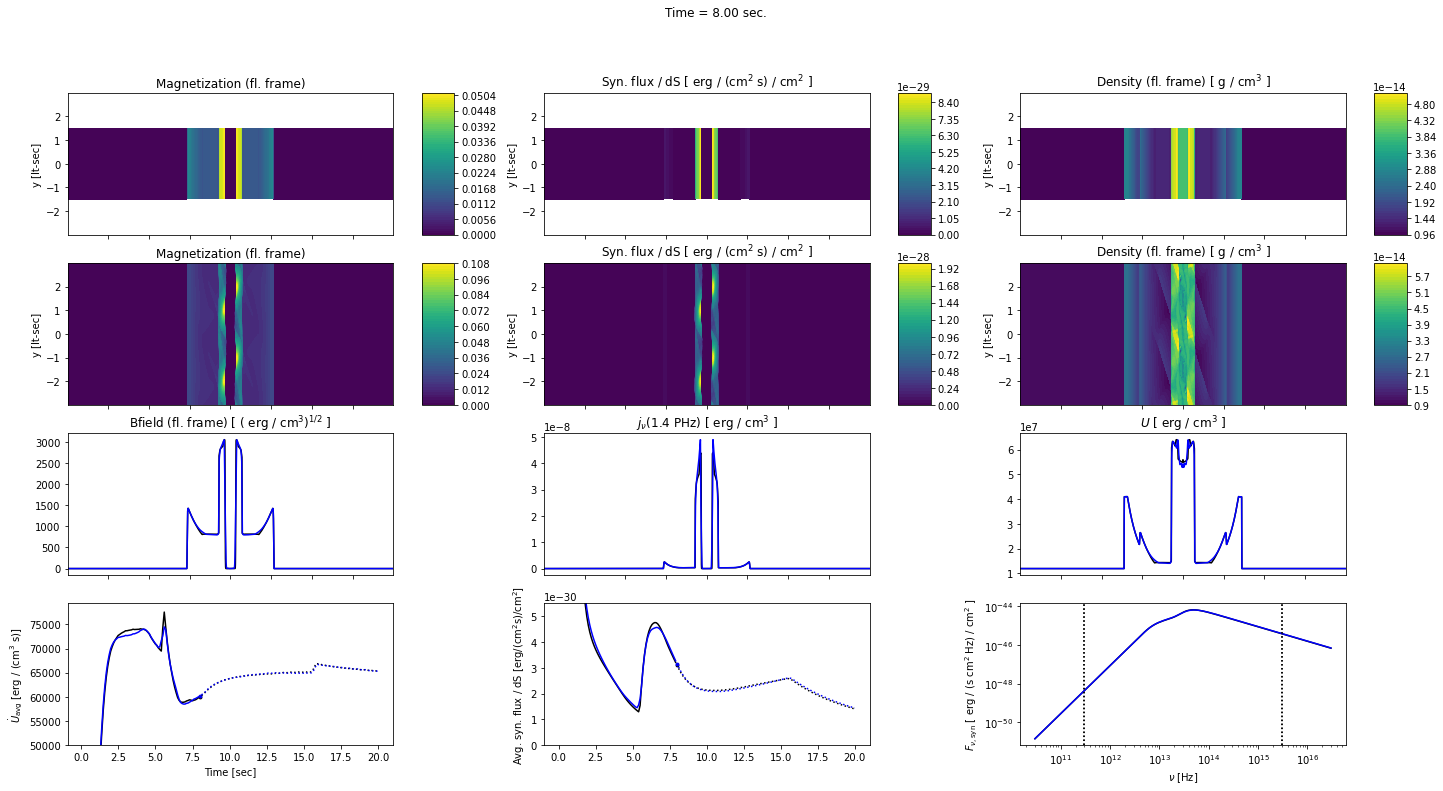

 - frame done.


In [16]:
if processing_type == 'comparison' and not in_script:
    comparison_frame(80, history_comp=history_comp, save=False)